In [59]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sys
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
sys.path.append('../src')
from utils.load_data import load_metadata, load_trial
from preprocessing.preprocessing import preprocess_deep_learning,preprocess_time_domain,preprocess_frequency_domain,preprocess_and_epoch_trial
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2]:
base_path = '../data'
metadata = load_metadata(base_path)
train_df = metadata['train']
validation_df = metadata['validation']
test_df = metadata['test']
train_df.head()

,id,subject_id,task,trial_session,trial,label
0,1,S1,MI,1,1,Left
1,2,S1,MI,1,2,Right
2,3,S1,MI,1,3,Left
3,4,S1,MI,1,4,Left
4,5,S1,MI,1,5,Left


In [28]:
target_len = 1000

# Filter for subject S1
train_s1_df = train_df[train_df['subject_id'] == 'S1']
train_s1_df = train_s1_df[train_s1_df['task'] == 'MI']

train_trials = []
train_labels = []

# Loop over all trials for S1
for idx, row in train_s1_df.iterrows():
    try:
        trial_df = load_trial(row, 'train', base_path)

        # Run the full preprocessing and epoching pipeline
        epochs, raw_resampled = preprocess_and_epoch_trial(trial_df)

        if epochs is None or len(epochs) == 0:
            continue

        # Average over epochs to get a fixed representation (channels x time)
        epoch_data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
        avg_epoch = np.mean(epoch_data, axis=0)  # shape: (n_channels, n_times)

        # Ensure the fixed shape
        if avg_epoch.shape[1] < target_len:
            avg_epoch = np.pad(avg_epoch, ((0, 0), (0, target_len - avg_epoch.shape[1])), mode='constant')
        else:
            avg_epoch = avg_epoch[:, :target_len]

        # Flatten and append
        trial_flat = avg_epoch.flatten()
        train_trials.append(trial_flat)
        train_labels.append(row['label'])

    except Exception as e:
        print(f"Error processing trial {row['id']}: {e}")

# Convert to array
X_train = np.stack(train_trials)
y_train = LabelEncoder().fit_transform(train_labels)

X_train.shape, np.unique(y_train)

((80, 16000), array([0, 1], dtype=int64))

In [29]:
target_len = 1000   # same as used in training

val_trials = []
val_labels = []

validation_df = validation_df[validation_df['task'] == 'MI']  # Filter for MI task if needed

# Loop over all trials in validation set
for idx, row in validation_df.iterrows():
    try:
        trial_df = load_trial(row, 'validation', base_path)

        # Run the full preprocessing and epoching pipeline
        epochs, raw_resampled = preprocess_and_epoch_trial(trial_df)

        if epochs is None or len(epochs) == 0:
            continue

        # Average over epochs to get a fixed representation (channels x time)
        epoch_data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
        avg_epoch = np.mean(epoch_data, axis=0)  # shape: (n_channels, n_times)

        # Ensure fixed shape by padding or trimming
        if avg_epoch.shape[1] < target_len:
            avg_epoch = np.pad(avg_epoch, ((0, 0), (0, target_len - avg_epoch.shape[1])), mode='constant')
        else:
            avg_epoch = avg_epoch[:, :target_len]

        # Flatten and append
        trial_flat = avg_epoch.flatten()
        val_trials.append(trial_flat)
        val_labels.append(row['label'])

    except Exception as e:
        print(f"Error processing validation trial {row['id']}: {e}")

# Final conversion using np.array (not flattening the full array!)
X_val = np.array(val_trials)
y_val = LabelEncoder().fit_transform(val_labels)

print(f'Validation shape: {X_val.shape}, Labels: {np.unique(y_val)}')

c:\Users\PC\Desktop\EEG\eeg-signal-classification\notebooks\../src\preprocessing\preprocessing.py:858: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(
c:\Users\PC\Desktop\EEG\eeg-signal-classification\notebooks\../src\preprocessing\preprocessing.py:858: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(
c:\Users\PC\Desktop\EEG\eeg-signal-classification\notebooks\../src\preprocessing\preprocessing.py:858: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for 

Validation shape: (47, 16000), Labels: [0 1]


# SVM

SVM Accuracy: 0.5531914893617021
Classification Report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        26
           1       0.00      0.00      0.00        21

    accuracy                           0.55        47
   macro avg       0.28      0.50      0.36        47
weighted avg       0.31      0.55      0.39        47



d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


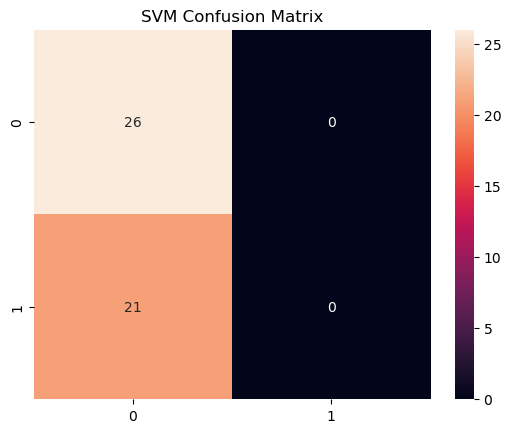

In [30]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_val)
print("SVM Accuracy:", accuracy_score(y_val, svm_preds))
print("Classification Report:\n", classification_report(y_val, svm_preds))
sns.heatmap(confusion_matrix(y_val, svm_preds), annot=True, fmt='d')
plt.title("SVM Confusion Matrix")
plt.show()


# KNN

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Use scaled versions for KNN

# Define and train the KNN model
knn = KNeighborsClassifier(n_neighbors=13, metric='euclidean')  # You can tune n_neighbors
knn.fit(X_train_scaled, y_train)

# Predict on validation data
y_pred = knn.predict(X_val_scaled)

# Evaluate the model
print("=== Classification Report ===")
print(classification_report(y_val, y_pred))

print("=== Accuracy Score ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.64      0.96      0.77        26
           1       0.88      0.33      0.48        21

    accuracy                           0.68        47
   macro avg       0.76      0.65      0.63        47
weighted avg       0.75      0.68      0.64        47

=== Accuracy Score ===
Accuracy: 0.6809


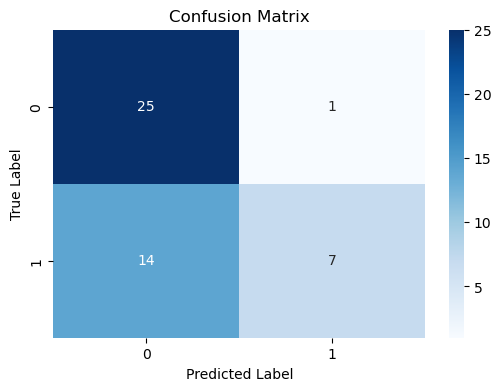

In [51]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Random Forest

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize and train the Random Forest model
rf = RandomForestClassifier(
    n_estimators=20000,      # Number of trees in the forest
    max_depth=None,        # Let the trees expand fully
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all processors
)

rf.fit(X_train_scaled, y_train)

# Predict on validation set
y_pred = rf.predict(X_val_scaled)

# Evaluation metrics
print("=== Classification Report ===")
print(classification_report(y_val, y_pred))

print("=== Accuracy Score ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.65      0.58      0.61        26
           1       0.54      0.62      0.58        21

    accuracy                           0.60        47
   macro avg       0.60      0.60      0.60        47
weighted avg       0.60      0.60      0.60        47

=== Accuracy Score ===
Accuracy: 0.5957


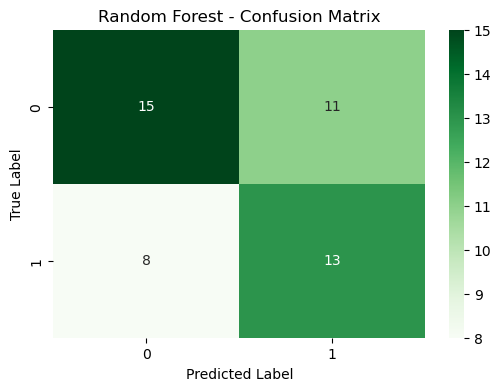

In [53]:
# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# XGBoost

In [61]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
# Convert data to DMatrix format (optional but recommended by XGBoost)
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled, label=y_val)

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',   # For multi-class classification
    'num_class': len(np.unique(y_train)),
    'eval_metric': 'mlogloss',
    'eta': 0.1,                     # Learning rate
    'max_depth': 6,
    'seed': 42
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict
y_pred = bst.predict(dval).astype(int)

# Evaluate
print("=== Classification Report ===")
print(classification_report(y_val, y_pred))

print("=== Accuracy Score ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.59      0.38      0.47        26
           1       0.47      0.67      0.55        21

    accuracy                           0.51        47
   macro avg       0.53      0.53      0.51        47
weighted avg       0.53      0.51      0.50        47

=== Accuracy Score ===
Accuracy: 0.5106


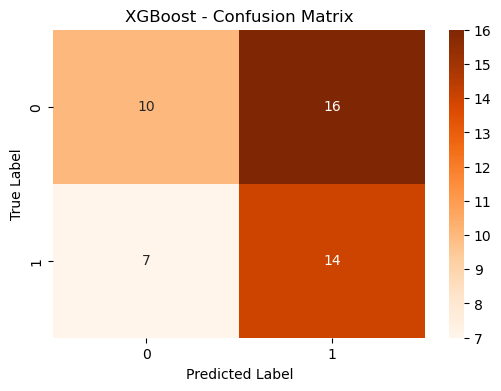

In [62]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()